In [1]:
import pyrealsense2 as rs
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Creating Depth and Color Images

In [2]:
width = 1280
height = 720
fps = 30

In [81]:
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, width, height, rs.format.z16, fps)
config.enable_stream(rs.stream.color, width, height, rs.format.rgb8, fps)

In [133]:
profile = pipeline.start(config)

In [134]:
align_to = rs.stream.color
align = rs.align(align_to)

In [135]:
frames = pipeline.wait_for_frames()

In [136]:
aligned_frames = align.process(frames)

depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

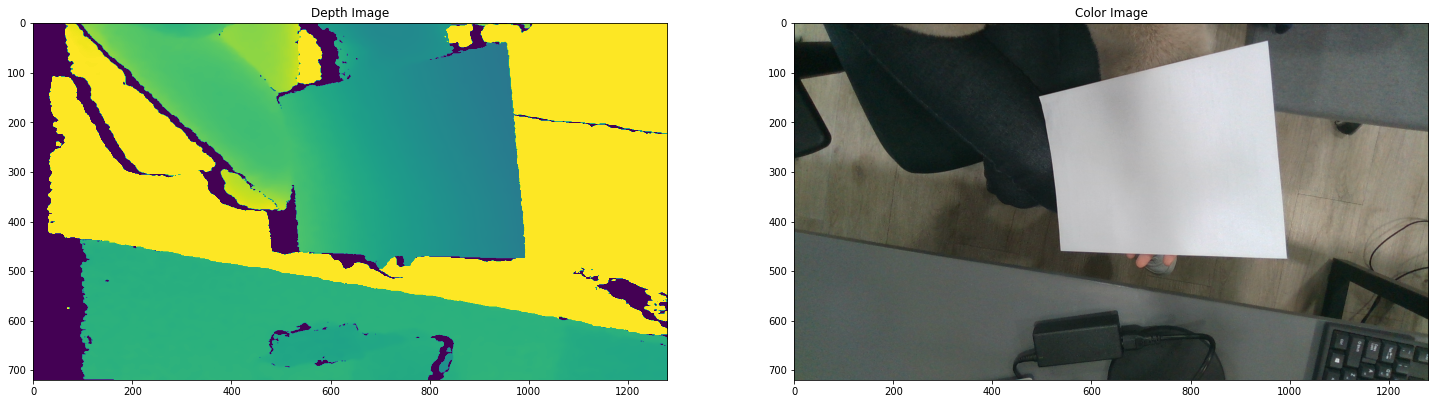

In [137]:
fig = plt.figure(figsize=(25,10))
row = 1
col = 2

ax1 = fig.add_subplot(row,col,1)
ax1.imshow(depth_image, vmin=200, vmax=800)
ax1.set_title("Depth Image")

ax2 = fig.add_subplot(row,col,2)
ax2.imshow(color_image)
ax2.set_title("Color Image")

plt.show()

In [138]:
pipeline.stop()

## Matrix Extraction

In [139]:
def mouse_handler(event,x,y,flag,data):
    if event == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(data['im'],(x,y),3,(0,255,0),5,16)
        cv2.imshow("Image",data["im"])
        if len(data["points"]) < 4:
            data['points'].append([x,y])
    
def get_four_points(im):
    data = {}
    data['im'] = im.copy()
    data['points'] = []

    cv2.imshow("Image",im)
    cv2.setMouseCallback("Image",mouse_handler,data)
    cv2.waitKey(0)

    points = np.array(data['points'],dtype=float)
    return points


In [140]:
cv2.imshow("Image", cv2.cvtColor(color_image,cv2.COLOR_RGB2BGR))

points_src = get_four_points(color_image)

cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x55f5272ccc10) is not the object's thread (0x55f5272699d0).
Cannot move to target thread (0x55f5272ccc10)

QObject::moveToThread: Current thread (0x55f5272ccc10) is not the object's thread (0x55f5272699d0).
Cannot move to target thread (0x55f5272ccc10)

QObject::moveToThread: Current thread (0x55f5272ccc10) is not the object's thread (0x55f5272699d0).
Cannot move to target thread (0x55f5272ccc10)

QObject::moveToThread: Current thread (0x55f5272ccc10) is not the object's thread (0x55f5272699d0).
Cannot move to target thread (0x55f5272ccc10)

QObject::moveToThread: Current thread (0x55f5272ccc10) is not the object's thread (0x55f5272699d0).
Cannot move to target thread (0x55f5272ccc10)

QObject::moveToThread: Current thread (0x55f5272ccc10) is not the object's thread (0x55f5272699d0).
Cannot move to target thread (0x55f5272ccc10)

QObject::moveToThread: Current thread (0x55f5272ccc10) is not the object's thread (0x55f5272699d0).
Cannot move to tar

In [141]:
points_src

array([[494., 149.],
       [539., 460.],
       [996., 476.],
       [955.,  36.]])

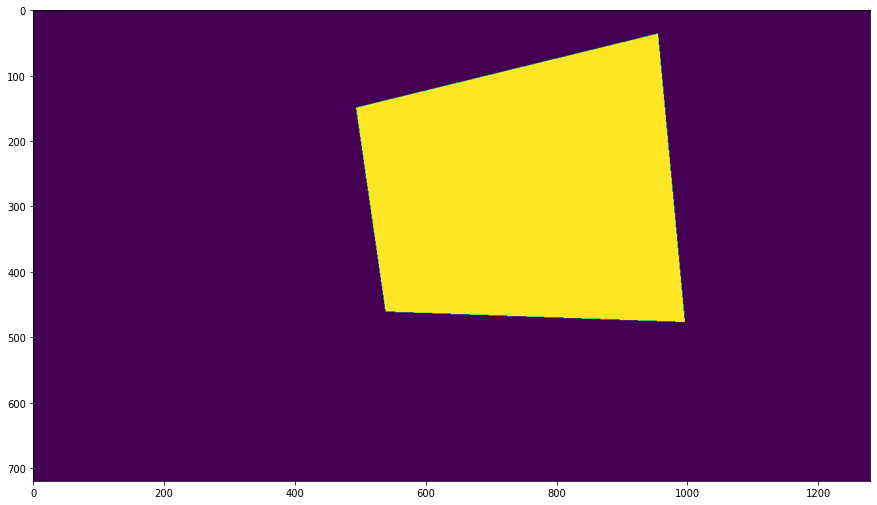

In [142]:
mask = np.zeros(color_image.shape[:2], dtype="uint8")

cv2.fillPoly(mask, np.int32([points_src]), 1)
plt.figure(figsize=(15,25))
plt.imshow(mask)

In [143]:
masked_depth = cv2.bitwise_and(depth_image,depth_image,mask=mask)

import math

deg_h = 65
deg_v = 40

px_h = masked_depth * math.tan(math.radians(deg_h/2)) / (depth_image.shape[1] / 2)
px_v = masked_depth * math.tan(math.radians(deg_v/2)) / (depth_image.shape[0] / 2)

area = px_h * px_v
paper_area = np.sum(area)

error = np.abs(paper_area - 62370)/62370 * 100

print("Area of the paper is {:0.2f}mm^2.".format(paper_area))
print("True value is 62370 mm^2.")
print("Percent error is {:0.2f}%.".format(error))

Area of the paper is 48415.80mm^2.
True value is 62370 mm^2.
Percent error is 22.37%.


## Conclusion
- 종이를 최대한 평면으로 두고 측정했을 때에는 percent error가 13~15%를 웃돔
- 종이를 기울이면 percent error가 증가함 (20%~)
- percent error 발생 이유 추측
    - 종이의 어떤 면적이든 항상 평평하다는 가정의 오류
    - 종이와 카메라가 평행하지 않을때 픽셀이 충분히 작아 image plane에 비춰진 면적이 실제 면적과 같다는 가정의 오류